### CRNN

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


In [42]:
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [43]:
train_data_dir = "./stockpred/bb/str3/train"
validation_data_dir = "./stockpred/bb/str3/val"
test_data_dir = "./stockpred/bb/str3/test"

In [44]:
train_data = datasets.ImageFolder(root=train_data_dir, transform=transform_train)
val_data = datasets.ImageFolder(root=validation_data_dir, transform=transform_val)
test_data = datasets.ImageFolder(root=test_data_dir, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [45]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.rnn = nn.GRU(input_size=32 * 16 * 16, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 3)  # 이진 분류를 가정
        self.to(device)  # 모델을 MPS 디바이스로 이동
    
    def forward(self, x):
        x = x.to(device)  # 입력 데이터를 MPS 디바이스로 이동
        x = self.cnn(x)
        x = x.view(x.size(0), -1, x.size(1) * x.size(2) * x.size(3))  # RNN 입력을 위한 텐서 재배치
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])  # 마지막 시퀀스의 출력만 사용
        return x

In [53]:
model = CRNN().to(device)  # 모델을 MPS 디바이스로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            outputs = model(images).to(device)
            loss = criterion(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [55]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

In [56]:
train(
    model, 
    train_loader, 
    criterion, 
    optimizer, 
    num_epochs = 2
)

Epoch [1/2], Loss: 0.0101
Epoch [2/2], Loss: 0.0379


In [57]:
test(model, val_loader)

Accuracy of the model on the test images: 20.161290322580644%


In [58]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})

In [52]:
results_df

,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
379,0,1
380,0,1
381,0,1
382,0,1


In [32]:
data = pd.read_csv('./stockpred/data/stock_data.csv', index_col = 0)
data.index = pd.to_datetime(data.index)

In [36]:
ret = data['Close'].pct_change().fillna(0)

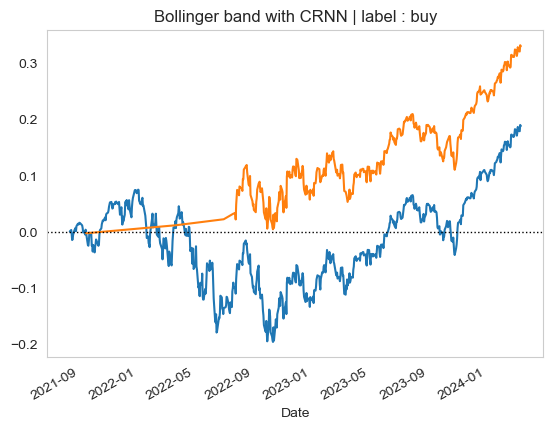

In [52]:
ret[-649:].cumsum().plot(
    grid = False,
    title = 'Bollinger band with CRNN | label : buy'
)
ret[-649:].iloc[
    results_df[results_df['Predicted'] == 1].index
].cumsum().plot(
    grid = False
)
plt.axhline(0, lw = 1, ls = ':', c = 'k')
plt.show()

strategy 2

In [ ]:
train_data_dir = "./stockpred/bb/str1/train"
validation_data_dir = "./stockpred/bb/str1/val"

